# Machine Learning Pipeline

There are several steps to building a scalable Machine Learning pipeline. These include:

1. Defining a problem
2. Data ingestion
3. Data preparation
4. **Data segregation**
5. **Model training**
6. **Candidate model evaluation**
7. Model deployment
8. Performance monitoring

We will focus on steps 4, 5 and 6. Note that the other steps are just as if not more important. The ML model is only ever useful if the data fed into it is meaningful, hence why most of the time is generally not spent on the model, but on data preparation, feature engineering etc. Some of these techniques were covered in the Data Analysis notebook, and creating useful features will require strong domain knowledge.

After having defined a problem and metrics to measure impact, and the necessary data being prepared, we are now ready to build the model. We will walk through a very simple example of what this might look like.

## Overview

Below is the fruit data set. For each fruit name, we have some descriptions about the fruit. Our goal is to predict the fruit_name given the other charactestrics of the fruit.

In [86]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

fruits = pd.read_csv('fruit_data_with_colors.txt', sep='\t')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


## Initial Data Exploration

In this example, the data is already clean, and in a format that can be fed into the model. Usually this would not be the case. It is important to quickly visualise and explore the data to understand the data.

In [28]:
fruits.profile_report()

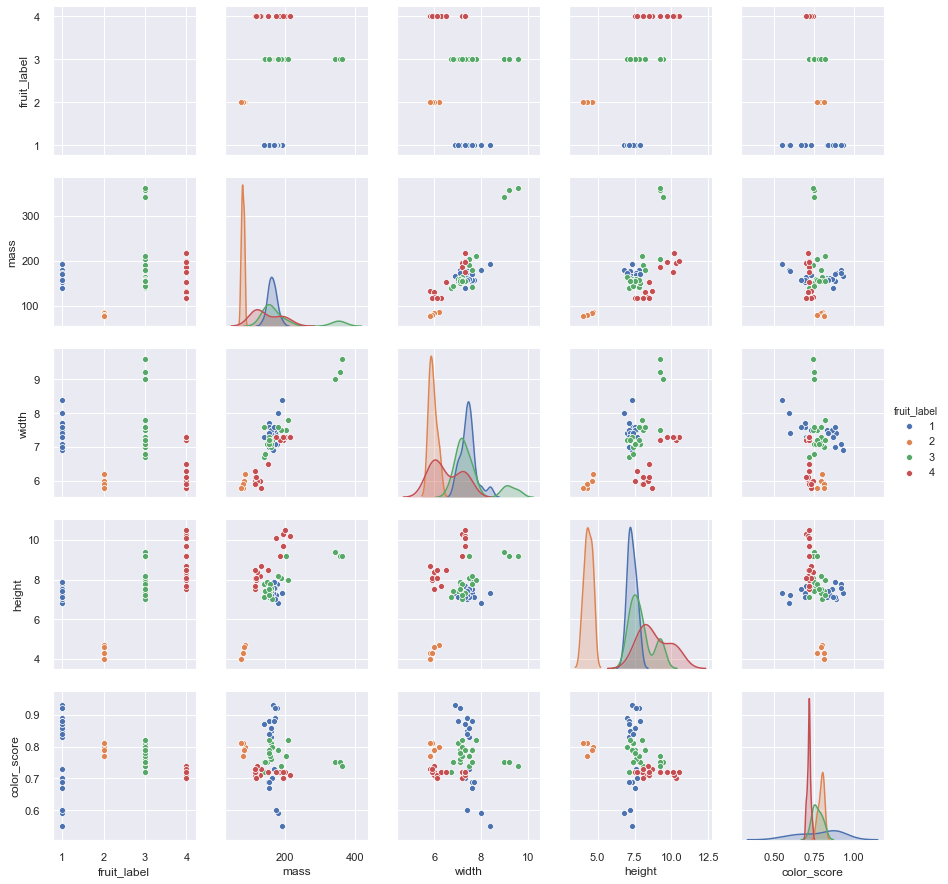

In [37]:
sns.set()

sns.pairplot(fruits, hue='fruit_label');

## Building a ML pipeline

We will look at building Pipelines that can help speed up the process of model building and finding the best model. When building a model, some things to might come to mind are:

1. How should I treat the data (e.g. standardise inputs? scale inputs)? 
2. What classifier should I choose?
3. What classifier parameters should I use?

Rather than writing new code for each choice above (and commenting / uncommenting code all the time), we can build this all into a model pipeline. Doing this allows us to easily test many different models assumptions, and changing classifiers / data treatment becomes a very simple change.

**Data Segregation**

In [56]:
X = fruits.drop(columns=['fruit_label','fruit_name','fruit_subtype'])
y = fruits['fruit_label']

# split into train, test (shuffle to ensure to bias in sampling due to order)
print("Split data into train and test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True) 

Split data into train and test...


**Model Training**

In [99]:
pipeline = Pipeline([
    ('StandardScaler', StandardScaler())
    #('MinMaxScaler', MinMaxScaler())
    ,('LogisticRegression', LogisticRegression())
])

parameters = {
    'LogisticRegression__class_weight':['balanced',None]
    ,'LogisticRegression__C':[0.2,0.4,0.6,0.8,1]
}

cv = GridSearchCV(pipeline, parameters, cv=3, scoring='f1_weighted', iid=True)

# Fit to the training set
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('StandardScaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('LogisticRegression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

**Candidate Model Evaluation**

In [100]:
# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Best parameters: {}".format(cv.best_params_))
print("Training Accuracy: {}".format(cv.score(X_train, y_train)))
print("Test Accuracy: {}".format(cv.score(X_test, y_test)))

Best parameters: {'LogisticRegression__C': 0.6, 'LogisticRegression__class_weight': None}
Training Accuracy: 0.7373737373737373
Test Accuracy: 0.5224358974358975


***
## What if we wanted to test many different classifiers?

We could just easily change the pipeline to use a different model. All we need to change is the classifier in the pipeline, and the parameters dictionary.

In [101]:
pipeline = Pipeline([
    ('StandardScaler', StandardScaler())
    ,('XGBoost', XGBClassifier())
])

parameters = {
    'XGBoost__objective':['multi:softprob']
    ,'XGBoost__n_estimators':[1,2,3,5,10,100]
    ,'XGBoost__max_depth':[1,2,3]
    ,'XGBoost__learning_rate': [0.005,0.01,0.05,0.1]
    ,'XGBoost__subsample': [0.5,0.8,0.9]
}

cv = GridSearchCV(pipeline, parameters, cv=3, scoring='f1_weighted', iid=True)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Best parameters: {}".format(cv.best_params_))
print("Training Accuracy: {}".format(cv.score(X_train, y_train)))
print("Test Accuracy: {}".format(cv.score(X_test, y_test)))

Best parameters: {'XGBoost__learning_rate': 0.005, 'XGBoost__max_depth': 1, 'XGBoost__n_estimators': 2, 'XGBoost__objective': 'multi:softprob', 'XGBoost__subsample': 0.8}
Training Accuracy: 0.8727272727272727
Test Accuracy: 0.5782676524864024


We can even automate the fitting and evaluation of many different classifiers at once! There are many ways to do this. We can use a loop, or can make a class that one can feed multiple classifiers as parameters. Below is an example of a class that does just that.

In [112]:
class multiple_model_grid_search_cv:

    def __init__(self, pipelines, params):
        self.pipelines = pipelines
        self.params = params
        self.keys = pipelines.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=-1, verbose=0, scoring=None, refit=True):
        """fits multiple model pipelines as defined in self.pipeline"""
        
        print("Running GridSearchCV for:")
        for key in self.keys:
            print("    %s..." % key)
            pipeline = self.pipelines[key]
            params = self.params[key]
            gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit, iid=True,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs
        print("    Fit of all models is complete!")
        
    def score(self, X, y):
        print("Computing summaries for each model:")
        i = 1
        for key in self.keys:
            model = self.grid_searches[key]
            print("Model {}: {}" .format(i, key))
            print("    Optimal parameters for {}: {}" .format(key, model.best_params_))
            print("    Optimal model's accuracy: {}".format(model.score(X,y)))
            print("\n")
            i += 1

In [114]:
# define Logistic pipeline with standard scaler
logistic1_pipeline = Pipeline([
    ('StandardScaler', StandardScaler())
    #('MinMaxScaler', MinMaxScaler())
    ,('LogisticRegression', LogisticRegression())
])

logistic1_parameters = {
    'LogisticRegression__class_weight':['balanced',None]
    ,'LogisticRegression__C':[0.2,0.4,0.6,0.8,1]
}

# define Logistic pipeline with minmax scaler
logistic2_pipeline = Pipeline([
    ('MinMaxScaler', MinMaxScaler())
    ,('LogisticRegression', LogisticRegression())
])

logistic2_parameters = {
    'LogisticRegression__class_weight':['balanced',None]
    ,'LogisticRegression__C':[0.2,0.4,0.6,0.8,1]
}

# define xgboost pipeline
xgboost_pipeline = Pipeline([
    ('StandardScaler', StandardScaler())
    ,('XGBoost', XGBClassifier())
])

xgboost_parameters = {
    'XGBoost__objective':['multi:softprob']
    ,'XGBoost__n_estimators':[1,2,3,5,10,100]
    ,'XGBoost__max_depth':[1,2,3]
    ,'XGBoost__learning_rate': [0.005,0.01,0.05,0.1]
    ,'XGBoost__subsample': [0.5,0.8,0.9]
}

# group all pipelines together
all_pipeline = {
    'Logistic1':logistic1_pipeline
    ,'Logistic2':logistic2_pipeline
    ,'XGBoost':xgboost_pipeline
}

all_parameters = {
    'Logistic1':logistic1_parameters
    ,'Logistic2':logistic2_parameters
    ,'XGBoost':xgboost_parameters
}

# fit all pipelines
model = mulll_pipelitiple_model_grid_search_cv(ane, all_parameters)
model.fit(X_train, y_train, cv=3, scoring='f1_weighted')
print("\n")

print("=========Train accuracy========")
model.score(X_train, y_train)

print("\n=========Test accuracy========")
model.score(X_test, y_test)

Running GridSearchCV for:
    Logistic1...
    Logistic2...
    XGBoost...
    Fit of all models is complete!


=========Train accuracy========
Computing summaries for each model:
Model 1: Logistic1
    Optimal parameters for Logistic1: {'LogisticRegression__C': 0.6, 'LogisticRegression__class_weight': None}
    Optimal model's accuracy: 0.7373737373737373


Model 2: Logistic2
    Optimal parameters for Logistic2: {'LogisticRegression__C': 0.2, 'LogisticRegression__class_weight': None}
    Optimal model's accuracy: 0.5541125541125541


Model 3: XGBoost
    Optimal parameters for XGBoost: {'XGBoost__learning_rate': 0.005, 'XGBoost__max_depth': 1, 'XGBoost__n_estimators': 2, 'XGBoost__objective': 'multi:softprob', 'XGBoost__subsample': 0.8}
    Optimal model's accuracy: 0.8727272727272727



=========Test accuracy========
Computing summaries for each model:
Model 1: Logistic1
    Optimal parameters for Logistic1: {'LogisticRegression__C': 0.6, 'LogisticRegression__class_weight': None}
  